In [2]:
import os
os.getcwd()

'/home/onyxia/work/hackathon-un-2022/notebooks'

In [4]:
os.chdir("..")
import utils.functions as fc

In [83]:
from importlib import reload
fc = reload(fc)

In [26]:
ship_data_enriched = fc.create_ship_data_enriched()
AIS = fc.read_ais_parquet()
#AIS_enriched = fc.enrich_AIS_data(
#    AIS, ship_data_enriched
#)

In [24]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [36]:
AIS_enriched = fc.enrich_AIS_data(
    AIS, ship_data_enriched
)

In [37]:
AIS_enriched.drop_duplicates('mmsi').agg({"mmsi": "nunique"})

mmsi    1862
dtype: int64

In [40]:
fc.count_boats(AIS_enriched, unique_id = "mmsi")

mmsi    1862
dtype: int64

In [77]:
fc.count_boats(AIS_enriched, by = "ShiptypeLevel1")


ShiptypeLevel1
Cargo Carrying                 1331
Work Vessel                     510
Non Seagoing Merchant Ships       9
Non Merchant                      7
Non Propelled                     4
Non Ship Structure                1
dtype: int64

In [75]:
fc.count_boats(AIS_enriched, by = "ShipTypeLevel2")

ShipTypeLevel3
General Cargo            591
Bulk Dry                 263
Towing / Pushing         257
Chemical                 159
Oil                      159
Fish Catching            105
Other Activities          64
Container                 57
Offshore Supply           27
Passenger                 26
Dredging                  18
Liquefied Gas             17
Ro-Ro Cargo               17
Other Fishing             13
Passenger/Ro-Ro Cargo     13
Other Dry Cargo           12
Research                  12
Bulk Dry / Oil            11
Other Offshore             7
Other activities           7
Yacht                      7
Tanker                     4
Barge                      4
Other Non-Seagoing         4
Refrigerated Cargo         3
Other Bulk Dry             3
Non-ship structures        1
Dry Cargo/Passenger        1
dtype: int64

In [76]:
fc.count_boats(AIS_enriched, by = "ShipTypeLevel3")

ShipTypeLevel3
General Cargo            591
Bulk Dry                 263
Towing / Pushing         257
Chemical                 159
Oil                      159
Fish Catching            105
Other Activities          64
Container                 57
Offshore Supply           27
Passenger                 26
Dredging                  18
Liquefied Gas             17
Ro-Ro Cargo               17
Other Fishing             13
Passenger/Ro-Ro Cargo     13
Other Dry Cargo           12
Research                  12
Bulk Dry / Oil            11
Other Offshore             7
Other activities           7
Yacht                      7
Tanker                     4
Barge                      4
Other Non-Seagoing         4
Refrigerated Cargo         3
Other Bulk Dry             3
Non-ship structures        1
Dry Cargo/Passenger        1
dtype: int64

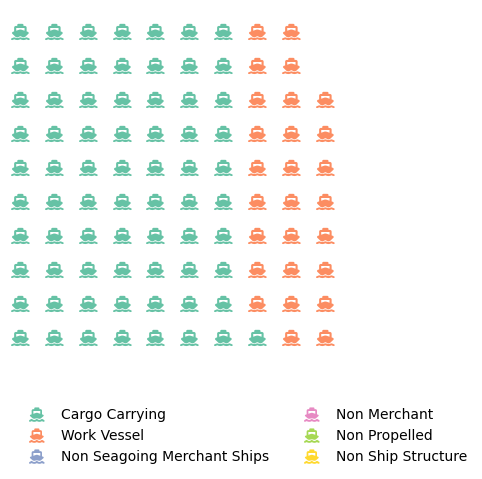

In [81]:
fig = fc.waffle_chart_zone(AIS_enriched, by = "ShiptypeLevel1")

In [88]:
import geopandas as gpd
import folium

ports = pd.read_csv('https://msi.nga.mil/api/publications/download?type=view&key=16920959/SFH00000/UpdatedPub150.csv')

ports = gpd.GeoDataFrame(
    ports, geometry = gpd.points_from_xy(ports['Longitude'], ports['Latitude'])
    )

center, sw, ne = fc.bbox_geopandas(ports, "Latitude", "Longitude")

m = folium.Map(location = center, tiles='Stamen Toner')
    
for i in range(0,len(ports)):
    folium.Marker([ports.iloc[i]['Latitude'], ports.iloc[i]['Longitude']]).add_to(m)

In [90]:
m